In [1]:


import os


# define cache for sentencebert
os.environ['XDG_CACHE_HOME'] = 'home/msds2022/mpingol/ .cache'

import time
import re
import string
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

import torch
from sentence_transformers import SentenceTransformer, util
import umap.umap_ as umap

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle

from automl_prec import AutoML
import tensorflow as tf

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import itertools
from itertools import chain

import pickle
import shap
import re
import time
import string

import torch
import tensorflow as tf

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import *
from nltk import word_tokenize

from keybert import KeyBERT
from keyphrase_vectorizers import KeyphraseCountVectorizer
from keyphrase_vectorizers import KeyphraseTfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import pairwise_distances
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

from datasets import load_dataset, load_metric
from transformers import BigBirdPegasusForConditionalGeneration, AutoTokenizer, PegasusTokenizer

from sentence_transformers import SentenceTransformer, util
import umap.umap_ as umap

from catboost import CatBoostClassifier, Pool
import seaborn as sns
#from ctfidf import CTFIDFVectorizer
from scipy import stats
import json

ModuleNotFoundError: No module named 'datasets'

In [ ]:
tf.config.list_physical_devices('GPU')

In [ ]:
!nvidia-smi

### Extract Data

In [3]:
df = pd.read_excel('../data/cleaned/research_profile_v4.xlsx')

In [4]:
def remove_punctuations(data):
    punct = set(string.punctuation)
    punct.add("’")
    data = ("").join([ch for ch in data if ch not in punct])
    return data

def remove_stopwords(data):
    stop_words = stopwords.words('english')
    data = (" ").join([word for word in data.split() if word not in stop_words])
    return data

def lemma_corpus(data):
    lemmatizer = WordNetLemmatizer()
    data = (" ").join([lemmatizer.lemmatize(word) for word in data.split()])
    return data

def replace_delimiter(data):
    data = re.sub(r"; ", " ", data)
    data = re.sub(r", ", " ", data)
    data = re.sub(r";", " ", data)
    data = re.sub(r",", " ", data)
    return data

In [5]:
kp_df = df[['Research Title', 'Abstract', 'Keywords', 'SDG']].copy()
kp_df.columns = ['title', 'abstract', 'keywords', 'sdg']
kp_df

,title,abstract,keywords,sdg
0,Disaster Risk Reduction and Long-Term Risk Res...,The CHED PHERNet-AdMU Program has been conduct...,disaster risk reduction and long-term risk res...,NaN
1,Antimycotic Activity Of Nostoc Linckia Specie...,The warm tropical climate of the Philippines a...,microbiology;anti-staphylococcus aureus;plant ...,NaN
2,Green Chemistry Perspective Among Stem 12 Seni...,The study was conducted to determine the ‚ÄúGr...,green chemistry;attitude;practices;knowledge;s...,NaN
3,Solid Waste Management System of Barangay Deet,This study aimed to establish a Solid Waste Ma...,NaN,NaN
4,Multivariate Analysis on Tobacco Farming System,Farming systems refers to the utilization of t...,NaN,NaN
...,...,...,...,...
1274,Scientific Learning Motivations as Predictors ...,"Teachers, as life-long learners, hold personal...",assessment practices; scientific learning moti...,4
1275,Agricultural information system and communicat...,The study was conducted to assess the agricult...,Agricultural information system; Communication...,9
1276,Paperless Smart Classroom Attendance System Us...,"As people's demand and lifestyle change, the d...",Paperless; fingerprint biometric; SMS; attenda...,9
1277,Students' Grade Inquiry Kiosk Using Biometric ...,Technological advancements have helped educato...,Grades; Kiosk; Fingerprint Biometrics; SMS; Au...,9


In [6]:
# process titles
kp_df['title_processed'] = None
for idx in kp_df.index:
    try:
        data = kp_df['title'].loc[idx]
        data = remove_punctuations(data)
        data = remove_stopwords(data)
        data = lemma_corpus(data)
        kp_df['title_processed'].loc[idx] = data
    except:
        continue
        
# process keywords
kp_df['keywords_processed'] = None
for idx in kp_df.index:
    try:
        data = kp_df['keywords'].loc[idx]
        data = replace_delimiter(data)
        data = remove_stopwords(data)
        data = lemma_corpus(data)
        kp_df['keywords_processed'].loc[idx] = data
    except:
        continue
        
# process abstract
kp_df['abstract_processed'] = None
for idx in kp_df.index:
    try:
        data = kp_df['abstract'].loc[idx]
        data = remove_punctuations(data)
        data = remove_stopwords(data)
        data = lemma_corpus(data)
        kp_df['abstract_processed'].loc[idx] = data
    except:
        continue

In [7]:
kp_df['keywords_processed'].fillna("", inplace=True)
kp_df['abstract_processed'].fillna("", inplace=True)

In [8]:
# create corpus 1
kp_df['corpus_1'] = None
for idx in kp_df.index:
    try:
        kp_df['corpus_1'].loc[idx] = (kp_df['title'].loc[idx] + 
                                      kp_df['abstract'].loc[idx])
    except:
        continue
        
# create corpus 1
kp_df['corpus_2'] = None
for idx in kp_df.index:
    try:
        kp_df['corpus_2'].loc[idx] = (kp_df['title'].loc[idx] + 
                                      kp_df['abstract'].loc[idx] + 
                                      kp_df['keywords'].loc[idx])
    except:
        continue
        
# create processed corpus 3
kp_df['corpus_3'] = None
for idx in kp_df.index:
    try:
        kp_df['corpus_3'].loc[idx] = (kp_df['title_processed'].loc[idx] + 
                                      kp_df['abstract_processed'].loc[idx] + 
                                      kp_df['keywords_processed'].loc[idx])
    except:
        continue

In [9]:
sdg_df = kp_df[['corpus_3', 'sdg']].copy()
sdg_df.columns = ['corpus', 'sdg']
sdg_df.head()

,corpus,sdg
0,Disaster Risk Reduction LongTerm Risk Resilien...,NaN
1,Antimycotic Activity Of Nostoc Linckia Species...,NaN
2,Green Chemistry Perspective Among Stem 12 Seni...,NaN
3,Solid Waste Management System Barangay DeetThi...,NaN
4,Multivariate Analysis Tobacco Farming SystemFa...,NaN


Before Processing


<class 'int'>    629
<class 'str'>     15
Name: sdg, dtype: int64

After Processing


<class 'int'>    644
Name: sdg, dtype: int64

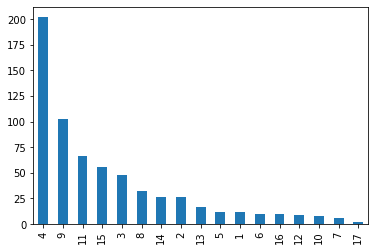

In [10]:
# sdg processessing
sdg_pred = sdg_df[sdg_df['sdg'].isnull()].index
sdg_idx = sdg_df[(sdg_df['sdg'].notnull())].index
sdg_df = sdg_df[['corpus', 'sdg']].loc[sdg_idx].copy()

print("Before Processing")
display(sdg_df['sdg'].apply(lambda x: type(x)).value_counts())
sdg_df['sdg_type'] = sdg_df['sdg'].apply(lambda x: type(x))

for idx in sdg_df[sdg_df['sdg_type'] == str].index:
    sdg_df['sdg'].loc[idx] = np.random.choice(sdg_df['sdg'].loc[idx].split(';'))
    
sdg_df = sdg_df.drop('sdg_type', axis=1)
sdg_df['sdg'] = sdg_df['sdg'].apply(lambda x: int(x))

print("After Processing")
display(sdg_df['sdg'].apply(lambda x: type(x)).value_counts())

sdg_df['sdg'].value_counts().plot(kind='bar');

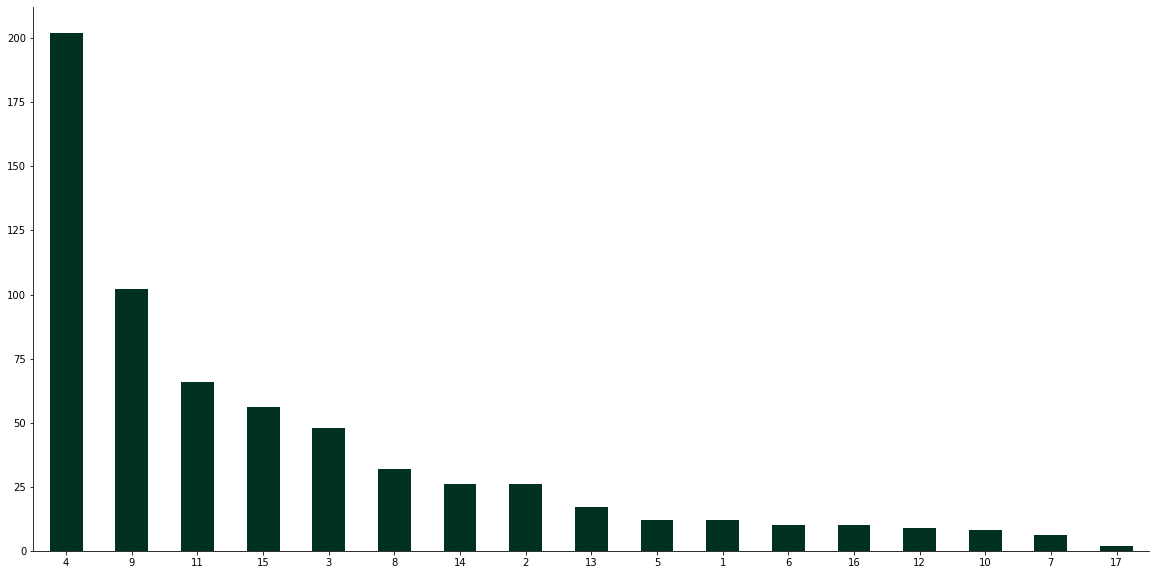

In [23]:
sdg_df['sdg'].value_counts().plot(kind='bar', figsize=(20,10), color='#013220');
# plt.xlabel('SDG Identifier');
# plt.ylabel('Research Count')
plt.xticks(rotation = 0)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False);

In [17]:
50 - sdg_df['sdg'].value_counts()

4    -152
9     -52
11    -16
15     -6
3       2
8      18
14     24
2      24
13     33
5      38
1      38
6      40
16     40
12     41
10     42
7      44
17     48
Name: sdg, dtype: int64

4 Quality Education
9 Industry, Innovation, and Infrastructure
11 Responsible Consumption and Production

10 Reduced Inequality
7 Affordable and Clean Energy
17 Partnerships for the Goals

### EDA

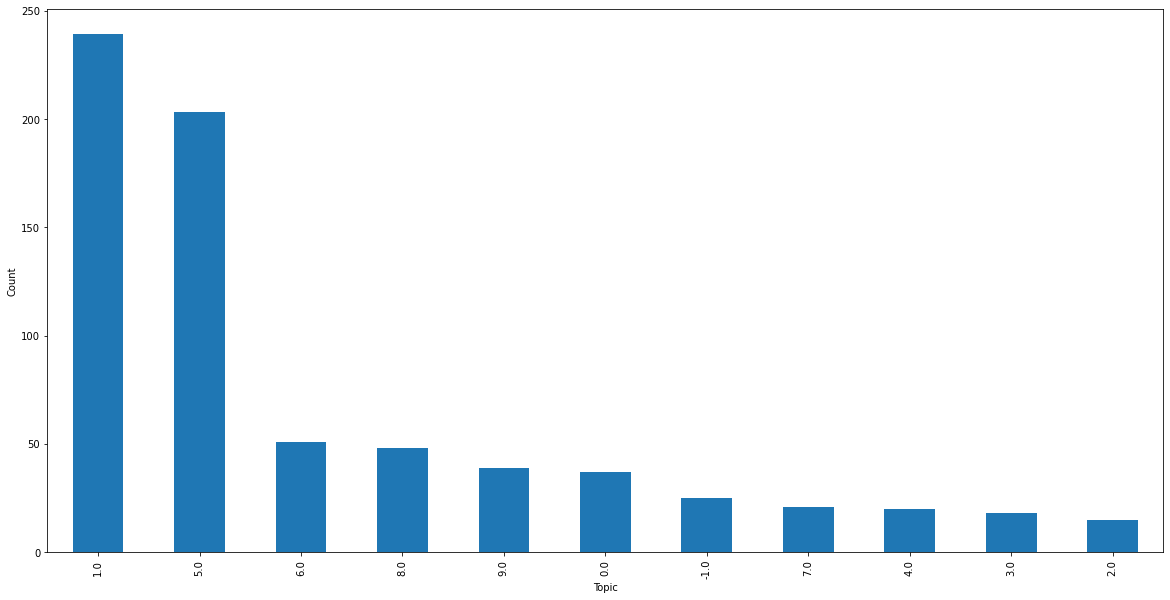

In [12]:
df.Topic.value_counts().plot.bar(figsize=(20,10))
plt.xlabel('Topic')
plt.ylabel('Count');

Note:
- Highly imbalanced dataset

### Preprocess

In [13]:
# load sentence transformer model
# model = SentenceTransformer('allenai/scibert_scivocab_uncased')
model = SentenceTransformer('allenai/specter')
model.max_seq_length = 512

PermissionError: [Errno 13] Permission denied: 'home/msds2022/mpingol/ .cache/torch/sentence_transformers/allenai_specter/config.json'

In [64]:
# encode abstract using pretrained model
start_time = time.time()
embeddings = model.encode(sdg_df.corpus.tolist(), convert_to_tensor=True)
end_time = time.time()
print("Time for computing embeddings:", str(end_time - start_time))

Time for computing embeddings: 5.089216947555542


### Model Training 

#### Baseline Models

In [65]:
X = pd.DataFrame(embeddings.cpu().numpy())
y = sdg_df.reset_index(drop=True)['sdg']

# le = LabelEncoder()
# y = le.fit_transform(y)


In [35]:
counts = pd.Series(y).value_counts()
pcc = (counts / counts.sum()) ** 2
pcc = pcc.sum() * 1.25
print("Proportional Chance Criterion (PCC): ", pcc)

Proportional Chance Criterion (PCC):  0.2636758372085765


In [ ]:
C = [1e-5, 1e-4, 1e-3, .01, 0.1, 10, 100, 1000, 10000]
n_neighbors = list(range(1, 51))
max_depth = list(range(1, 11))

In [ ]:
automl_tree = AutoML(['dtr', 'rfr'])
splits = automl_tree.split_data(X, y, shuffle=True
                                num_trials=10, 
                                test_size=0.25)

In [ ]:
automl_linear_l1 = AutoML(['lso'])
splits = automl_linear_l1.split_data(X, y, shuffle=True, 
                                     num_trials=20,
                                     test_size=0.25)
automl_linear_l1.train_model(X, y, param_grid= {'C' : C}, 
                        fixed_params={'penalty' : 'l1'})
linearl1_summary = automl_linear_l1.generate_summary()

In [ ]:
automl_linear_l2 = AutoML(['rdg'])
splits = automl_linear_l2.split_data(X, y, shuffle=True, 
                                     num_trials=20, 
                                     test_size=0.25)
automl_linear_l2.train_model(X, y, param_grid= {'C' : C}, 
                        fixed_params={'penalty' : 'l2'})
linearl2_summary = automl_linear_l2.generate_summary()

In [ ]:
automl_knc = AutoML('knr')
splits = automl_knc.split_data(X, y, num_trials=5,
                               test_size=0.25, 
                               shuffle=True)
automl_knc.train_model(X, y, param_grid={'n_neighbors' : range(1,5)})
knc_summary = automl_knc.generate_summary()

In [ ]:
df1 = pd.concat([tree_summary, 
                linearl1_summary, 
                linearl2_summary]).reset_index(drop=True)
knc_summary = pd.Series(knc_summary, index=df1.columns)
df1.loc[len(df)] = knc_summary
display(df1)

Decision Tree:  80%|████████  | 8/10 [00:16<00:04,  2.05s/it]

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Logistic Regression (l1):  60%|██████    | 12/20 [01:09<00:45,  5.71s/it]

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Logistic Regression (l1):  70%|███████   | 14/20 [01:21<00:34,  5.71s/it]

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Logistic Regression (l1):  75%|███████▌  | 15/20 [01:26<00:28,  5.65s/it]

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Linear SVM (l1):  40%|████      | 8/20 [06:48<10:16, 51.38s/it]

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Linear SVM (l1):  45%|████▌     | 9/20 [07:38<09:19, 50.83s/it]

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Linear SVM (l1):  60%|██████    | 12/20 [10:11<06:47, 50.93s/it]

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Linear SVM (l1):  70%|███████   | 14/20 [11:51<05:02, 50.36s/it]

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Linear SVM (l1):  90%|█████████ | 18/20 [15:09<01:38, 49.35s/it]

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Logistic Regression (l2):   5%|▌         | 1/20 [01:35<30:16, 95.58s/it]

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Logistic Regression (l2):  10%|█         | 2/20 [03:09<28:17, 94.30s/it]

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Logistic Regression (l2):  65%|██████▌   | 13/20 [20:04<10:47, 92.43s/it]

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Linear SVM (l2):  70%|███████   | 14/20 [02:21<00:58,  9.78s/it]

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Linear SVM (l2):  75%|███████▌  | 15/20 [02:31<00:49,  9.93s/it]

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Linear SVM (l2):  90%|█████████ | 18/20 [03:03<00:20, 10.22s/it]

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Linear SVM (l2):  95%|█████████▌| 19/20 [03:13<00:10, 10.27s/it]

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


knn Classification: 100%|██████████| 5/5 [00:09<00:00,  1.81s/it]


,Machine Learning Method,Test Precision,Best Parameter,Top Predictor Variable,Run Time
0,Decision Tree,0.246290,max_depth = 8,693,20.626652
1,Random Forest,0.338980,max_depth = 10,693,28.202364
2,Logistic Regression (l1),0.456387,C = 10000,274,115.130597
3,Linear SVM (l1),0.455427,C = 10000,454,1011.194698
4,Logistic Regression (l2),0.464995,C = 10,454,1811.203948
5,Linear SVM (l2),0.465972,C = 0.1,454,203.443836
1279,knn Classification,0.478084,n_neighbors = 1,NA,9.031808


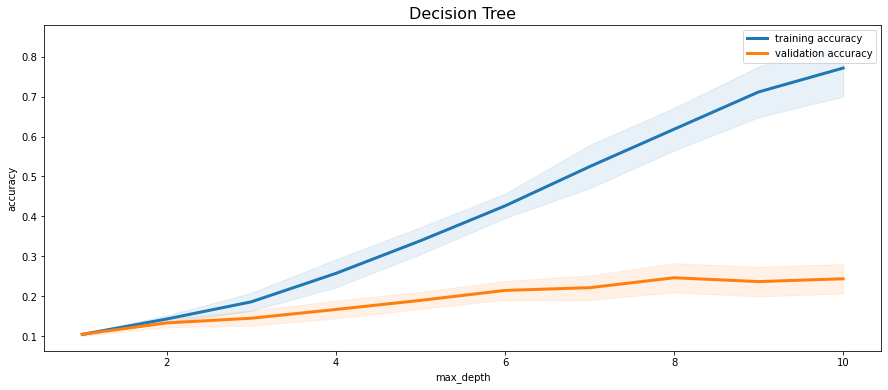

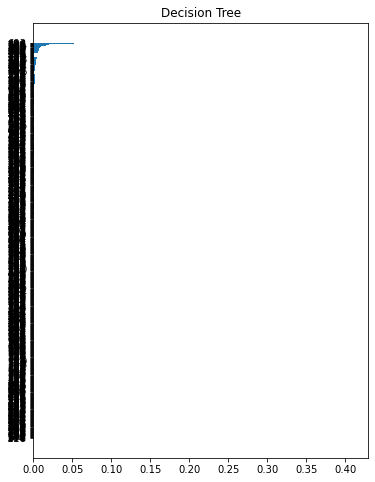

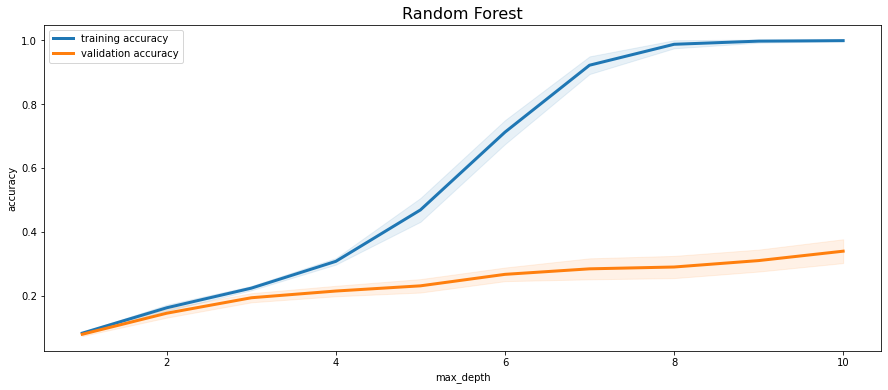

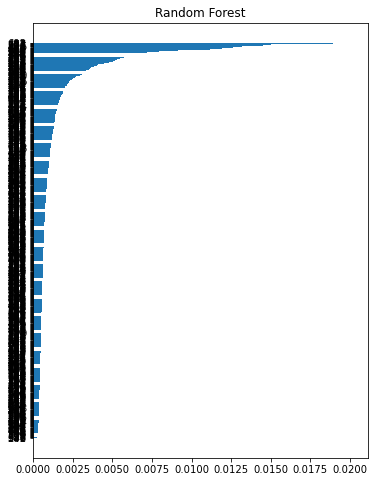

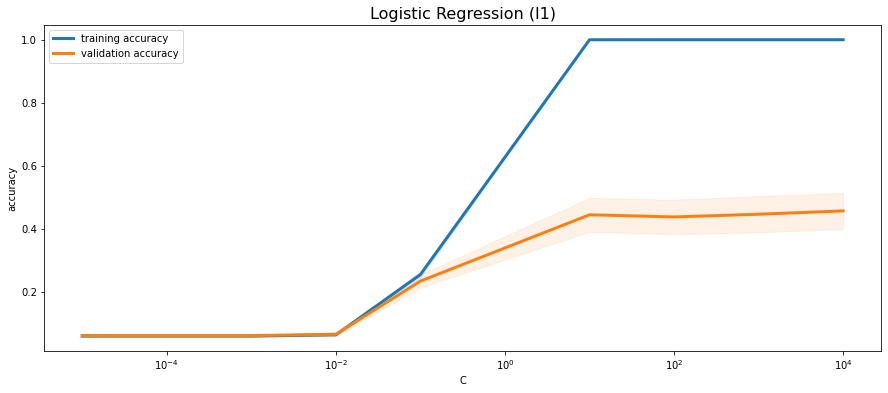

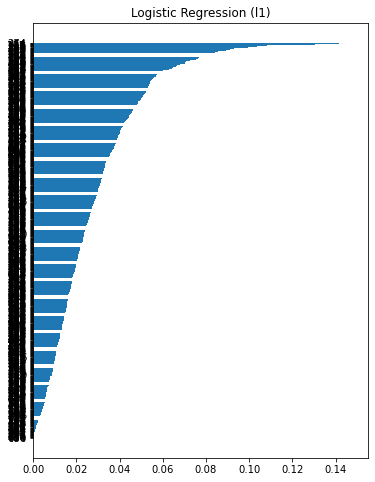

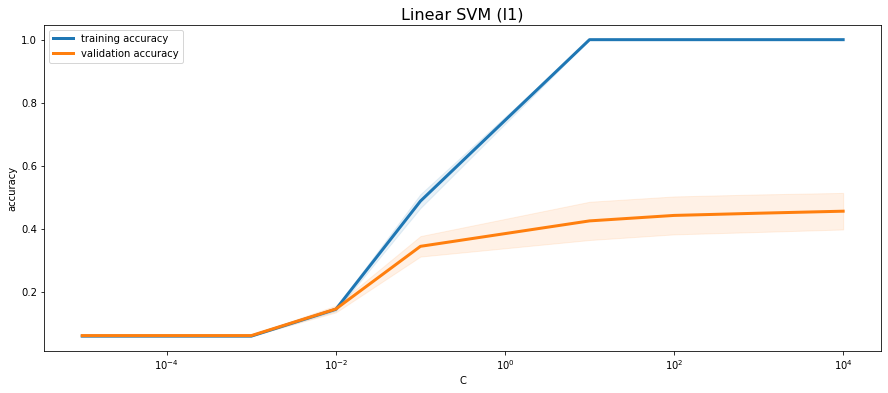

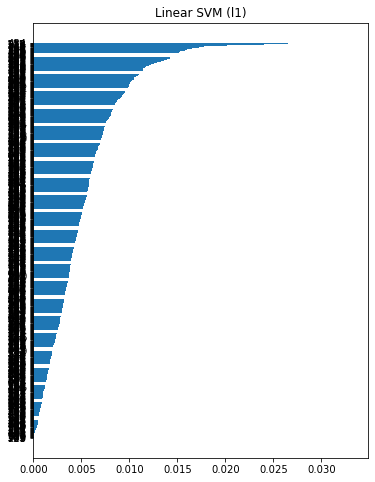

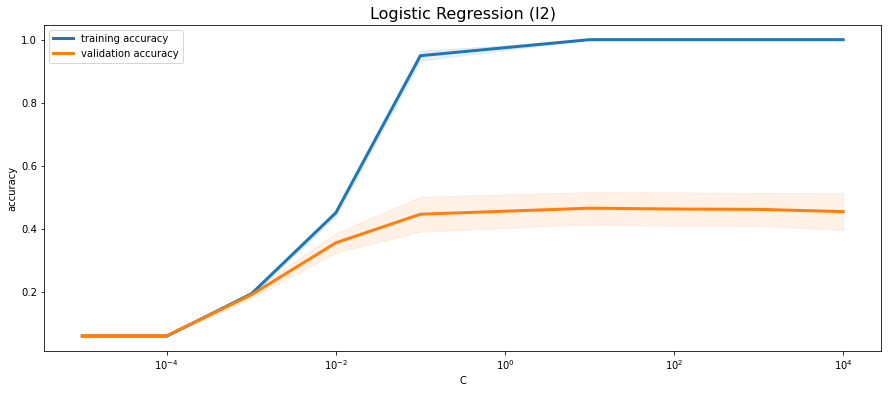

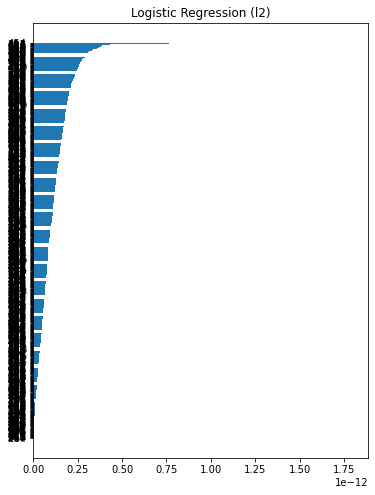

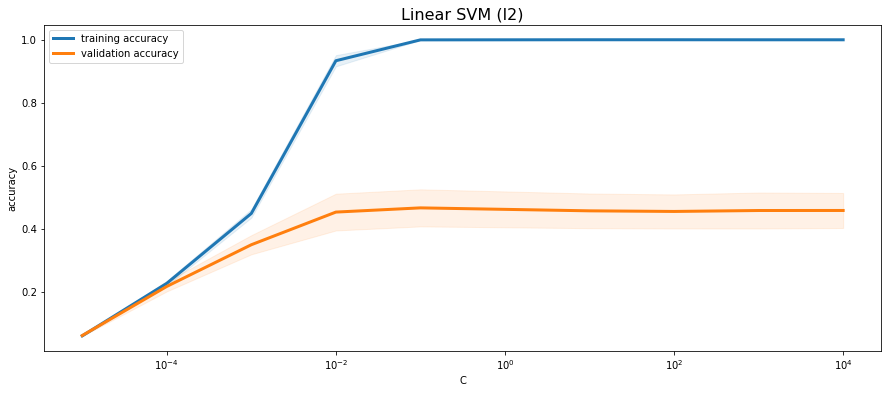

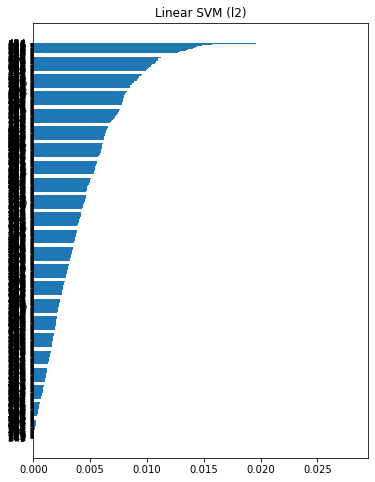

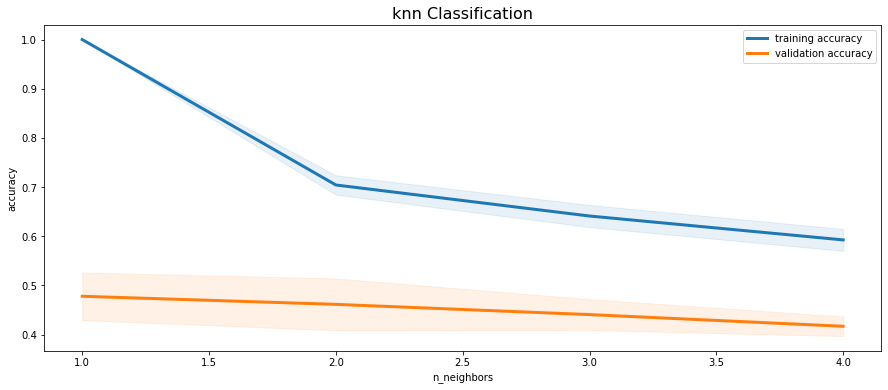

In [66]:
C = [1e-5, 1e-4, 1e-3, .01, 0.1, 10, 100, 1000, 10000]
n_neighbors = list(range(1, 51))
max_depth = list(range(1, 11))

automl_tree = AutoML(['dtc', 'rfc'])
splits = automl_tree.split_data(X, y, shuffle=True, 
                                num_trials=10, stratify=True, 
                                test_size=0.25)
automl_tree.train_model(X, y, 
                        param_grid={'max_depth':max_depth})
tree_summary = automl_tree.generate_summary()

automl_linear_l1 = AutoML(['log', 'svl'])
splits = automl_linear_l1.split_data(X, y, shuffle=True, 
                                     num_trials=20, stratify=True,
                                     test_size=0.25)
automl_linear_l1.train_model(X, y, param_grid= {'C' : C}, 
                        fixed_params={'penalty' : 'l1'})
linearl1_summary = automl_linear_l1.generate_summary()

automl_linear_l2 = AutoML(['log', 'svl'])
splits = automl_linear_l2.split_data(X, y, shuffle=True, 
                                     num_trials=20, stratify=True, 
                                     test_size=0.25)
automl_linear_l2.train_model(X, y, param_grid= {'C' : C}, 
                        fixed_params={'penalty' : 'l2'})
linearl2_summary = automl_linear_l2.generate_summary()

automl_knc = AutoML('knc')
splits = automl_knc.split_data(X, y, num_trials=5, stratify=True, 
                               test_size=0.25, 
                               shuffle=True)
automl_knc.train_model(X, y, param_grid={'n_neighbors' : range(1,5)})
knc_summary = automl_knc.generate_summary()


df1 = pd.concat([tree_summary, 
                linearl1_summary, 
                linearl2_summary]).reset_index(drop=True)
knc_summary = pd.Series(knc_summary, index=df1.columns)
df1.loc[len(df)] = knc_summary
display(df1)

Notes:
- Models took time to train
- Mostly overfitting

### Evaluation

In [ ]:
(X_train, X_test, 
 y_train, y_test) = train_test_split(X, y,
                                    test_size=0.25,
                                    random_state=143, 
                                    shuffle=True,
                                    stratify=y)

model = LogisticRegression(C =0.1, penalty='l2')
model.fit(X_train, y_train);

In [67]:
(X_train, X_test, 
 y_train, y_test) = train_test_split(X, y,
                                    test_size=0.25,
                                    random_state=143, 
                                    shuffle=True,
                                    stratify=y)

model = LinearSVC(C =0.1, penalty='l2')
model.fit(X_train, y_train);

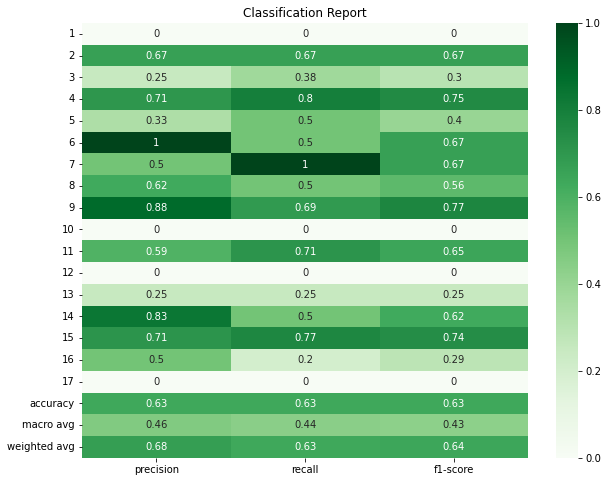

In [68]:
from sklearn.metrics import classification_report, confusion_matrix
plt.figure(figsize=(10, 8))
clf_report = classification_report(model.predict(X_test), 
                                   y_test,
                                   output_dict=True, 
                                   zero_division=0)

clf_report_df = pd.DataFrame(clf_report).iloc[:-1, :].T

sns.heatmap(clf_report_df, annot=True, cmap='Greens')
plt.title('Classification Report');

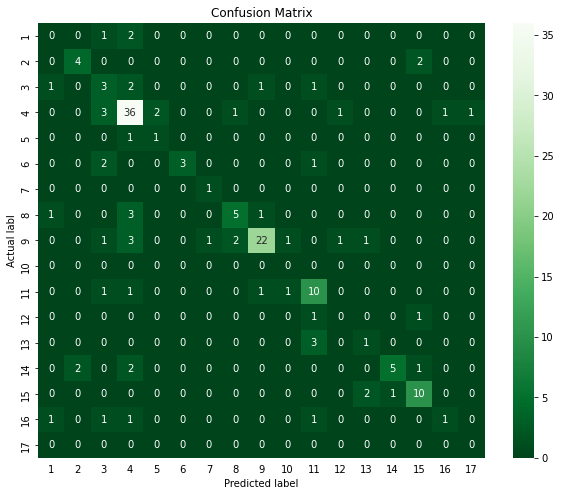

In [69]:
plt.figure(figsize=(10, 8))
cf_matrix = confusion_matrix(model.predict(X_test), y_test,
                            )

cf_df = pd.DataFrame(cf_matrix)
cf_df.columns = [(col + 1) for col in cf_df.columns]
cf_df.index = [(col + 1) for col in cf_df.index]

sns.heatmap(cf_df, annot=True, cmap='Greens_r')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('Actual labl')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False      # ticks along the bottom edge are off
) # labels along the bottom edge are off

In [39]:
sdg_df

,corpus,sdg
270,Determination Households‚Äô Willingness To Pay...,11
271,Work Attitude Accomplishment Work A Better Pre...,4
272,Evaluation Teachers‚Äô Competencies Agricultur...,4
273,Comparative Households‚Äô Preferences Wetland ...,11
274,Rooting Performance Mayapis Shoreapalosapis St...,9
...,...,...
1236,Water Demand Management Improving Access Water...,6
1237,Erythromycin Exposure Disrupts Life Cycle Stag...,15
1238,Rediscovery lost type solving mysterious ident...,15
1239,Statistics Probability Grade 11,4


In [40]:
kp_df

,title,abstract,keywords,sdg,title_processed,keywords_processed,abstract_processed,corpus_1,corpus_2,corpus_3
0,Disaster Risk Reduction and Long-Term Risk Res...,The CHED PHERNet-AdMU Program has been conduct...,disaster risk reduction and long-term risk res...,NaN,Disaster Risk Reduction LongTerm Risk Resilien...,disaster risk reduction long-term risk resilie...,The CHED PHERNetAdMU Program conducting resear...,Disaster Risk Reduction and Long-Term Risk Res...,Disaster Risk Reduction and Long-Term Risk Res...,Disaster Risk Reduction LongTerm Risk Resilien...
1,Antimycotic Activity Of Nostoc Linckia Specie...,The warm tropical climate of the Philippines a...,microbiology;anti-staphylococcus aureus;plant ...,NaN,Antimycotic Activity Of Nostoc Linckia Species...,microbiology anti-staphylococcus aureus plant ...,The warm tropical climate Philippines interact...,Antimycotic Activity Of Nostoc Linckia Specie...,Antimycotic Activity Of Nostoc Linckia Specie...,Antimycotic Activity Of Nostoc Linckia Species...
2,Green Chemistry Perspective Among Stem 12 Seni...,The study was conducted to determine the ‚ÄúGr...,green chemistry;attitude;practices;knowledge;s...,NaN,Green Chemistry Perspective Among Stem 12 Seni...,green chemistry attitude practice knowledge su...,The study conducted determine ‚ÄúGreen Chemist...,Green Chemistry Perspective Among Stem 12 Seni...,Green Chemistry Perspective Among Stem 12 Seni...,Green Chemistry Perspective Among Stem 12 Seni...
3,Solid Waste Management System of Barangay Deet,This study aimed to establish a Solid Waste Ma...,NaN,NaN,Solid Waste Management System Barangay Deet,,This study aimed establish Solid Waste Managem...,Solid Waste Management System of Barangay Deet...,None,Solid Waste Management System Barangay DeetThi...
4,Multivariate Analysis on Tobacco Farming System,Farming systems refers to the utilization of t...,NaN,NaN,Multivariate Analysis Tobacco Farming System,,Farming system refers utilization combination ...,Multivariate Analysis on Tobacco Farming Syst...,None,Multivariate Analysis Tobacco Farming SystemFa...
...,...,...,...,...,...,...,...,...,...,...
1259,"Capacity Building for Bangsamoro History, Cult...","To date, there are only a handful of Bangsamor...",zambasulta,NaN,Capacity Building Bangsamoro History Culture T...,zambasulta,To date handful Bangsamoro historian establish...,"Capacity Building for Bangsamoro History, Cult...","Capacity Building for Bangsamoro History, Cult...",Capacity Building Bangsamoro History Culture T...
1260,Optimization of Polyaniline Film Synthesis on ...,"Recently, diverse innovative processes in food...",polyaniline film synthesis on flexible substrates,NaN,Optimization Polyaniline Film Synthesis Flexib...,polyaniline film synthesis flexible substrate,Recently diverse innovative process food fresh...,Optimization of Polyaniline Film Synthesis on ...,Optimization of Polyaniline Film Synthesis on ...,Optimization Polyaniline Film Synthesis Flexib...
1261,Entrepreneurship Education for Fisherfolks and...,Ensuring proper health and nutrition of the pe...,farm-gate markets for aquatic products (eeffmap),NaN,Entrepreneurship Education Fisherfolks Aquafar...,farm-gate market aquatic product (eeffmap),Ensuring proper health nutrition people way re...,Entrepreneurship Education for Fisherfolks and...,Entrepreneurship Education for Fisherfolks and...,Entrepreneurship Education Fisherfolks Aquafar...
1262,Program Title: ICT-aided Community-based High ...,This project aims to facilitate the delivery o...,i-chives,NaN,Program Title ICTaided Communitybased High Val...,i-chives,This project aim facilitate delivery quicker r...,Program Title: ICT-aided Community-based High ...,Program Title: ICT-aided Community-based High ...,Program Title ICTaided Communitybased High Val...


In [ ]:
class_df = sdg_df.groupby(['generated_sdg'], as_index=False).agg({'corpus_processed': ' '.join})
class_df = pd.concat([class_df,sdg_excel['Title']], axis=1)

count_vectorizer = CountVectorizer(token_pattern=r'[a-z-]+', stop_words='english', ngram_range=(2, 5)).fit(class_df.corpus_processed)
count = count_vectorizer.transform(class_df.corpus_processed)
words = count_vectorizer.get_feature_names()

ctfidf = CTFIDFVectorizer().fit_transform(count, n_samples=len(sdg_df)).toarray()
words_per_class = {label: [words[idx2] for idx2 in ctfidf[idx1].argsort()[-10:]] for idx1, label in enumerate(class_df.Title)}

words_per_class

sdg_topics = pd.DataFrame()
sdg_topics['SDG'] = None
sdg_topics['Topics'] = None

In [44]:
topic_mapping

{-1: 'Outliers',
 5: 'CROP CULTIVATION',
 1: 'EDUCATION',
 8: 'GOVERNANCE / POLICY',
 6: 'DATA SCIENCE / COMPUTER VISION',
 4: 'LIVESTOCK AGRICULTURE',
 9: 'INDIGENOUS PEOPLE / TRADITION AND HISTORY',
 7: 'UTILITIES / TRANSPORTATION',
 2: 'BIODIVERSITY / CONSERVATIONISM',
 0: 'COVID-19 PANDEMIC',
 3: 'AQUACULTURE / FISHERIES'}

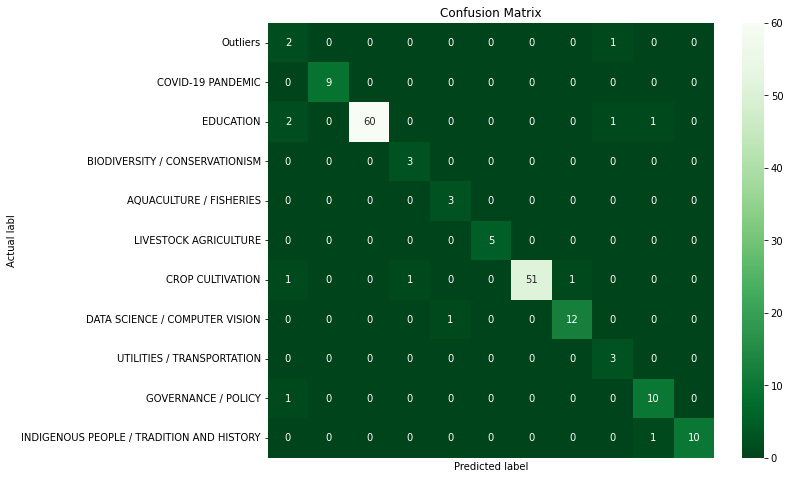

In [58]:
plt.figure(figsize=(10, 8))
cf_matrix = confusion_matrix(model.predict(X_test), y_test,
                            )

cf_df = pd.DataFrame(cf_matrix)
cf_df.columns = [topic_mapping[col - 1] for col in cf_df.columns]
cf_df.index = [topic_mapping[col - 1] for col in cf_df.index]


sns.heatmap(cf_df, annot=True, cmap='Greens_r')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('Actual labl')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

In [43]:
cf_df

,0,1,2,3,4,5,6,7,8,9,10
0,2,0,0,0,0,0,0,0,1,0,0
1,0,9,0,0,0,0,0,0,0,0,0
2,2,0,60,0,0,0,0,0,1,1,0
3,0,0,0,3,0,0,0,0,0,0,0
4,0,0,0,0,3,0,0,0,0,0,0
5,0,0,0,0,0,5,0,0,0,0,0
6,1,0,0,1,0,0,51,1,0,0,0
7,0,0,0,0,1,0,0,12,0,0,0
8,0,0,0,0,0,0,0,0,3,0,0
9,1,0,0,0,0,0,0,0,0,10,0


In [39]:
df[['Topic', 'Topic Name']].drop_duplicates().set_index('Topic').to_dict()['Topic Name']

{-1: 'Outliers',
 5: 'CROP CULTIVATION',
 1: 'EDUCATION',
 8: 'GOVERNANCE / POLICY',
 6: 'DATA SCIENCE / COMPUTER VISION',
 4: 'LIVESTOCK AGRICULTURE',
 9: 'INDIGENOUS PEOPLE / TRADITION AND HISTORY',
 7: 'UTILITIES / TRANSPORTATION',
 2: 'BIODIVERSITY / CONSERVATIONISM',
 0: 'COVID-19 PANDEMIC',
 3: 'AQUACULTURE / FISHERIES'}